In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import os

In [2]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

Using TensorFlow backend.


There should (intuitively) be some correlation between the 'over' columns and the 'outlier' columns \
After some rounds of validation, the training 'over' + 'outlier' together columns prove to be trash 

From running tree models, we can see that the most important features are the aggregated features \
Using this, we will try different combinations of features:
1. Aggregated features alone (cols)
2. Aggregated features + 'over' (cols2)
3. Aggregated features + 'outlier' (cols3)

The third combination gave the best results, hence hyperparameter tuning will be done on these features using RandomizedSearchCV

In [3]:
DATA_DIR = os.path.join(os.getcwd(), '../data/safety/total_df.csv')

# Without 'over' and 'outlier'
cols = ['acceleration_mean', 'acceleration_median', 'acceleration_std',
       'acceleration_spread', 'gyro_pc_mean', 'gyro_pc_median', 'gyro_pc_std',
       'gyro_pc_spread', 'speed_mean', 'speed_median', 'speed_std',
       'speed_spread', 'second_mean', 'second_median', 'second_std',
       'second_spread', 'label']

# Without 'outlier'
cols2 = ['acceleration_mean', 'acceleration_median', 'acceleration_std',
       'acceleration_spread', 'gyro_pc_mean', 'gyro_pc_median', 'gyro_pc_std',
       'gyro_pc_spread', 'speed_mean', 'speed_median', 'speed_std',
       'speed_spread', 'second_mean', 'second_median', 'second_std',
       'second_spread', 'over_speed', 'over_second', 'over_acceleration_x',
       'over_acceleration_y', 'over_acceleration_z', 'over_gyro_x',
       'over_gyro_y', 'over_gyro_z', 'label']

# Without 'over'
cols3 = ['acceleration_mean', 'acceleration_median', 'acceleration_std',
       'acceleration_spread', 'gyro_pc_mean', 'gyro_pc_median', 'gyro_pc_std',
       'gyro_pc_spread', 'speed_mean', 'speed_median', 'speed_std',
       'speed_spread', 'second_mean', 'second_median', 'second_std',
       'second_spread', 'num_non_speed_outlier',
       'num_speed_outlier', 'num_non_accel_outlier', 'num_accel_outlier',
       'num_non_gyro_outlier', 'num_gyro_outlier', 'label']


agg_diff_df = pd.read_csv(DATA_DIR)
agg_diff_df = agg_diff_df.drop('bookingid', axis='columns')
agg_diff_df = agg_diff_df[cols3]
agg_diff_df.head(n=10)

,acceleration_mean,acceleration_median,acceleration_std,acceleration_spread,gyro_pc_mean,gyro_pc_median,gyro_pc_std,gyro_pc_spread,speed_mean,speed_median,...,second_median,second_std,second_spread,num_non_speed_outlier,num_speed_outlier,num_non_accel_outlier,num_accel_outlier,num_non_gyro_outlier,num_gyro_outlier,label
0,9.883337,9.852269,0.619492,6.530989,-0.006583,-0.002863,0.099002,1.101352,9.003204,8.503366,...,1086.5,534.113894,1589.0,243,6,235,14,237,12,0
1,9.865608,9.847932,0.522142,5.819621,-0.006855,-0.003612,0.090770,1.123587,8.019369,7.206634,...,607.5,289.129088,1034.0,192,16,206,2,197,11,1
2,9.929590,9.877755,0.515173,5.168422,-0.012751,0.001369,0.117109,0.896289,3.157213,2.998761,...,97.0,356.319445,825.0,47,0,47,0,41,6,1
3,9.813434,9.791035,0.620066,13.349284,0.022429,0.024239,0.112628,1.166471,6.150996,3.310000,...,547.5,315.962793,1094.0,259,13,262,10,247,25,1
4,9.918090,9.904142,0.585346,7.280114,0.000480,0.004189,0.106469,1.161481,4.628921,1.936962,...,547.0,316.243577,1094.0,259,13,262,10,248,24,0
5,9.826470,9.789800,0.916836,8.572037,0.002651,-0.002687,0.072664,0.903745,12.176386,13.017325,...,481.0,276.761488,959.0,205,30,192,43,235,0,0
6,9.763213,9.646309,0.730155,9.416841,-0.000840,0.000250,0.078446,0.754180,5.384260,3.540000,...,268.0,130.510496,462.0,92,3,89,6,87,8,0
7,9.550677,9.494390,0.833292,9.474737,0.001922,-0.000612,0.110181,0.909695,8.702027,9.580000,...,187.0,108.397417,374.0,87,5,77,15,83,9,0
8,9.948639,9.877962,0.750480,5.686104,-0.004018,-0.003111,0.151980,0.988519,6.659024,5.192059,...,112.0,93.043769,299.0,48,6,49,5,45,9,0
9,9.873517,9.823053,0.425662,5.916028,-0.002192,0.000388,0.082987,0.767631,4.152211,3.702154,...,238.0,177.047431,555.0,100,9,106,3,104,5,0


### Downsampling

Downsample to ensure that the neural network learns to classify equally, and not focusing on one class etc \
Train set will have 50:50 distribution, test set will follow actual distribution of 75:25

In [4]:
# dist = agg_diff_df['label'].value_counts()
# actual_dist = dist[1] / (dist[0] + dist[1]) 
# actual_dist # About 25%

In [5]:
# Downsampling training set to get equal class distribution
seed = 199

np.random.seed(seed)

count_0 = agg_diff_df['label'].value_counts()[0]
count_1 = agg_diff_df['label'].value_counts()[1]

idx0 = agg_diff_df[agg_diff_df['label'] == 0].index.values
sample_0_idx = np.random.choice(idx0, count_1)

df_0 = agg_diff_df.iloc[sample_0_idx, :]
downsample_df = pd.concat([df_0, agg_diff_df[agg_diff_df['label'] == 1]]).sample(frac=1).reset_index(drop=True)

X = downsample_df.drop('label', axis=1)
y = downsample_df['label']

X_train, X_test2, y_train, y_test2 = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=seed)

In [6]:
# Reforming test set to have class distribution of 75% class 0 : 25% class 1
prop = count_1 / (count_0 + count_1)
sample_0_idx2 = [idx for idx in idx0 if idx not in sample_0_idx]

y_count = y_test2.value_counts()[1]
sample_0_idx2 = np.random.choice(sample_0_idx2, size=np.int((y_count / 25) * 75))

new_df0 = agg_diff_df.iloc[sample_0_idx2, :].sample(n=np.int((y_count / 25) * 75))
test = pd.merge(X_test2, y_test2, left_index=True, right_index=True)
test = test[test['label'] == 1]

df_merge = pd.concat([new_df0, test], axis=0).reset_index(drop=True).sample(frac=1)

X_test, y_test = df_merge.drop('label', axis=1), df_merge['label']

del X_test2, y_test2, df_merge, test, new_df0

In [7]:
# Checking distributions
print("Training class distribution : ")
print(y_train.value_counts())

print("Testing class distribution : ")
print(y_test.value_counts())

Training class distribution : 
1    3999
0    3940
Name: label, dtype: int64
Testing class distribution : 
0    2889
1     963
Name: label, dtype: int64


### Non-downsampling approach

Leaving distribution as is then see how it goes...

In [8]:
# seed = 13

# np.random.seed(seed)

# X = agg_diff_df.drop('label', axis=1)
# y = agg_diff_df['label']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
#                                                     random_state=seed, shuffle=True)

# print(y_train.value_counts())
# print(y_test.value_counts())

### Standardising data to have mean = 0 and standard deviation = 1

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_train_scaled.describe()

,acceleration_mean,acceleration_median,acceleration_std,acceleration_spread,gyro_pc_mean,gyro_pc_median,gyro_pc_std,gyro_pc_spread,speed_mean,speed_median,...,second_mean,second_median,second_std,second_spread,num_non_speed_outlier,num_speed_outlier,num_non_accel_outlier,num_accel_outlier,num_non_gyro_outlier,num_gyro_outlier
count,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,...,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03,7.939000e+03
mean,-1.117997e-15,-3.582131e-16,-5.544822e-17,-1.301040e-16,2.805362e-17,-5.848874e-18,-5.993023e-17,-6.174121e-18,3.027906e-16,6.368504e-17,...,1.164902e-17,-1.552271e-17,6.267817e-17,3.945005e-17,9.817062e-18,-1.298034e-16,-3.865293e-17,9.133224e-17,7.141843e-17,-2.261455e-16
std,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,...,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00
min,-1.403143e+01,-1.487927e+01,-1.263256e+00,-1.265030e+00,-7.505363e+01,-7.457329e+01,-6.390963e-01,-4.769338e-01,-1.987609e+00,-1.409070e+00,...,-1.755744e+00,-1.718727e+00,-1.882765e+00,-1.878490e+00,-1.775224e+00,-8.030272e-01,-1.709059e+00,-5.800865e-01,-1.716260e+00,-7.754690e-01
25%,-1.389243e-01,-1.059107e-01,-4.052873e-01,-4.342546e-01,-2.422009e-02,-8.605665e-03,-2.943770e-01,-2.756335e-01,-7.383328e-01,-7.663352e-01,...,-7.264760e-01,-7.311748e-01,-7.227561e-01,-7.502336e-01,-7.481078e-01,-5.755529e-01,-7.528046e-01,-5.018448e-01,-7.760707e-01,-4.570796e-01
50%,-1.701149e-02,1.429840e-02,-1.874991e-01,-1.923706e-01,9.958785e-04,-1.561686e-03,-1.994687e-01,-2.314391e-01,-2.150629e-01,-2.388728e-01,...,-1.396704e-01,-1.343923e-01,-1.233851e-01,-1.365864e-01,-1.625555e-01,-3.101662e-01,-1.459509e-01,-3.453614e-01,-1.584955e-01,-2.448200e-01
75%,1.127595e-01,1.334502e-01,9.040556e-02,1.231454e-01,2.565321e-02,7.447437e-03,-7.748910e-02,-1.606479e-01,6.101081e-01,6.079683e-01,...,5.685832e-01,5.514987e-01,6.032076e-01,6.188211e-01,6.149811e-01,1.447824e-01,6.080188e-01,4.584714e-02,6.342130e-01,7.356943e-02
max,4.721768e+01,4.991402e+01,1.586540e+01,1.694057e+01,3.429427e+01,3.467825e+01,2.857527e+01,1.822551e+01,4.312907e+00,3.527370e+00,...,1.518335e+01,1.361776e+01,1.412638e+01,1.407828e+01,1.571455e+01,8.030558e+00,1.391283e+01,1.269492e+01,1.147404e+01,1.507325e+01


In [10]:
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
X_test_scaled.describe()

,acceleration_mean,acceleration_median,acceleration_std,acceleration_spread,gyro_pc_mean,gyro_pc_median,gyro_pc_std,gyro_pc_spread,speed_mean,speed_median,...,second_mean,second_median,second_std,second_spread,num_non_speed_outlier,num_speed_outlier,num_non_accel_outlier,num_accel_outlier,num_non_gyro_outlier,num_gyro_outlier
count,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,...,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03
mean,-5.931926e-17,-9.702851e-16,2.048127e-16,-1.195032e-17,-1.862621e-17,1.458393e-17,-1.572663e-16,6.953305e-18,-2.386893e-16,-1.102081e-16,...,-1.325812e-17,-4.052372e-17,-2.556510e-17,-1.317165e-16,1.972001e-16,1.158644e-17,3.585455e-17,-4.340592e-17,1.339070e-16,-3.594823e-16
std,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,...,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00,1.000130e+00
min,-9.517856e+00,-9.678875e+00,-1.406150e+00,-1.379592e+00,-1.043166e+01,-9.735176e+00,-7.270629e-01,-4.629994e-01,-1.865650e+00,-1.395112e+00,...,-1.602576e+00,-1.568730e+00,-1.854968e+00,-1.842653e+00,-1.761975e+00,-7.863839e-01,-1.724276e+00,-5.614917e-01,-1.710210e+00,-7.886986e-01
25%,-9.932039e-02,-7.957876e-02,-4.246305e-01,-4.625899e-01,-3.243065e-01,-1.786610e-01,-3.213616e-01,-2.587445e-01,-7.470991e-01,-7.792574e-01,...,-6.799369e-01,-6.968992e-01,-7.427452e-01,-7.444038e-01,-7.706154e-01,-5.618027e-01,-7.563422e-01,-4.780220e-01,-7.737081e-01,-4.612986e-01
50%,-1.508900e-02,-2.272165e-03,-1.587854e-01,-1.717348e-01,-1.138947e-02,-5.136919e-02,-1.958964e-01,-2.089942e-01,-2.424808e-01,-2.662417e-01,...,-1.474542e-01,-1.492960e-01,-1.370580e-01,-1.459317e-01,-1.716688e-01,-3.176928e-01,-1.637299e-01,-3.110827e-01,-1.723753e-01,-2.157487e-01
75%,6.830606e-02,7.102765e-02,1.681711e-01,1.762076e-01,2.882491e-01,1.208569e-01,-2.988886e-02,-1.315703e-01,5.971829e-01,6.360827e-01,...,5.535852e-01,5.266646e-01,6.472530e-01,6.609556e-01,6.234845e-01,1.509984e-01,6.190121e-01,5.061919e-02,6.359736e-01,1.116513e-01
max,3.184967e+01,3.233498e+01,1.769901e+01,1.528644e+01,1.382471e+01,1.179318e+01,1.604057e+01,2.192246e+01,3.946116e+00,3.199149e+00,...,2.370491e+01,2.264750e+01,6.607630e+00,6.626252e+00,7.748884e+00,1.085278e+01,7.678506e+00,1.051215e+01,7.704098e+00,1.652257e+01


### Function to build model

Writing a function here so that the Keras sklearn wrapper can be used for the GridSearchCV (last section)

In [19]:
def build_model(num_layers=1, num_nodes=32, lr=0.001, dropout=False, opt="SGD", input_shape=(22,)):
    model = Sequential()
    model.add(Dense(num_nodes, activation='relu', input_shape=input_shape))
    
    if dropout:
        model.add(Dropout(rate=0.5))
    
    if num_layers > 1:
        for i in range(num_layers - 1):
            model.add(Dense(num_nodes, activation='relu'))
            if dropout:
                model.add(Dropout(rate=0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    
    if opt == "SGD":
        optimiser = optimizers.SGD(lr=lr)
    elif opt == "RMSprop":
        optimiser = optimizers.RMSprop(lr=lr)
    elif opt == "Adam":
        optimiser = optimizers.Adam(lr=lr)
    
    model.compile(loss="binary_crossentropy", 
               optimizer=optimiser,
               metrics=["accuracy"])
            
    return model

### Randomised grid search for hyperparameter tuning

In [20]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# keras.wrappers.scikit_learn.KerasClassifier(build_fn=None, **sk_params)

params = {'num_nodes' : [64, 128, 256, 512],
         'num_layers' : [1, 2], 
         'lr' : [0.0001, 0.001, 0.01, 0.1],
         'dropout' : [True, False],
         'opt' : ["SGD", "RMSprop", "Adam"]}

model = KerasClassifier(build_fn=build_model, epochs=60, batch_size=32)
# grid = GridSearchCV(model, param_grid=params, n_jobs=4, cv=5)
# grid.fit(X_train, y_train)

seed = 199
num_iter = 10

random_grid = RandomizedSearchCV(estimator=model, 
                                 param_distributions=params, 
                                 scoring='roc_auc', n_iter=num_iter, cv=5, n_jobs=-1,
                                 random_state=seed)
random_grid.fit(X_train_scaled, y_train)

/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/60
7939/7939 [==============================] - 2s 240us/step - loss: 0.6103 - accuracy: 0.6473
Epoch 2/60
7939/7939 [==============================] - 1s 157us/step - loss: 0.6039 - accuracy: 0.6539
Epoch 3/60
7939/7939 [==============================] - 1s 161us/step - loss: 0.5993 - accuracy: 0.6615
Epoch 4/60
7939/7939 [==============================] - 1s 163us/step - loss: 0.5964 - accuracy: 0.6603
Epoch 5/60
7939/7939 [==============================] - 1s 169us/step - loss: 0.5974 - accuracy: 0.6633
Epoch 6/60
7939/7939 [==============================] - 1s 169us/step - loss: 0.5970 - accuracy: 0.6593
Epoch 7/60
7939/7939 [==============================] - 1s 168us/step - loss: 0.5935 - accuracy: 0.6656
Epoch 8/60
7939/7939 [==============================] - 1s 172us/step - loss: 0.5919 - accuracy: 0.6627
Epoch 9/60
7939/7939 [==============================] - 1s 169us/step - loss: 0.5946 - accuracy: 0.6681
Epoch 10/60
7939/7939 [==============================] - 1s 181u

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x1a4ce18650>,
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'dropout': [True, False],
                                        'lr': [0.0001, 0.001, 0.01, 0.1],
                                        'num_layers': [1, 2],
                                        'num_nodes': [64, 128, 256, 512],
                                        'opt': ['SGD', 'RMSprop', 'Adam']},
                   pre_dispatch='2*n_jobs', random_state=199, refit=True,
                   return_train_score=False, scoring='roc_auc', verbose=0)

In [21]:
# This is actually worse than the current params, so ignore
print(random_grid.best_score_)
print(random_grid.best_params_)

0.7341532702727198
{'opt': 'RMSprop', 'num_nodes': 512, 'num_layers': 1, 'lr': 0.001, 'dropout': True}


### K-fold cross validation of train data

In [26]:
import datetime
start_time = datetime.datetime.now()

k = 5
num_val_samples = X_train_scaled.shape[0] // k
num_epochs = 60
batch_size = 32
all_val_loss = []
all_train_loss = []
all_val_acc = []
all_train_acc = []

for i in range(k):
    print('Processing fold {} of {}'.format(i + 1, k))

    val_data = X_train_scaled[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([X_train_scaled[:i * num_val_samples], 
                                         X_train_scaled[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([y_train[:i * num_val_samples], 
                                            y_train[(i + 1) * num_val_samples:]], axis=0)
    

    model = build_model(num_layers=2, num_nodes=128, lr=0.0001, opt="Adam", dropout=True, input_shape=((22,)))    
    history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, verbose=0,
                        validation_data=((val_data, val_targets)), batch_size=batch_size)

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    all_val_loss.append(val_loss)
    all_train_loss.append(loss)
    all_val_acc.append(val_acc)
    all_train_acc.append(acc)

    end_time = datetime.datetime.now()
    print("Total time taken: {} seconds".format((end_time - start_time).seconds))

Processing fold 1 of 5
Total time taken: 67 seconds
Processing fold 2 of 5
Total time taken: 137 seconds
Processing fold 3 of 5
Total time taken: 213 seconds
Processing fold 4 of 5
Total time taken: 294 seconds
Processing fold 5 of 5
Total time taken: 373 seconds


Train loss: 0.5935621542053799, train acc: 0.6637279391288757
Val loss: 0.5974864174978645, val acc: 0.6594833016395569


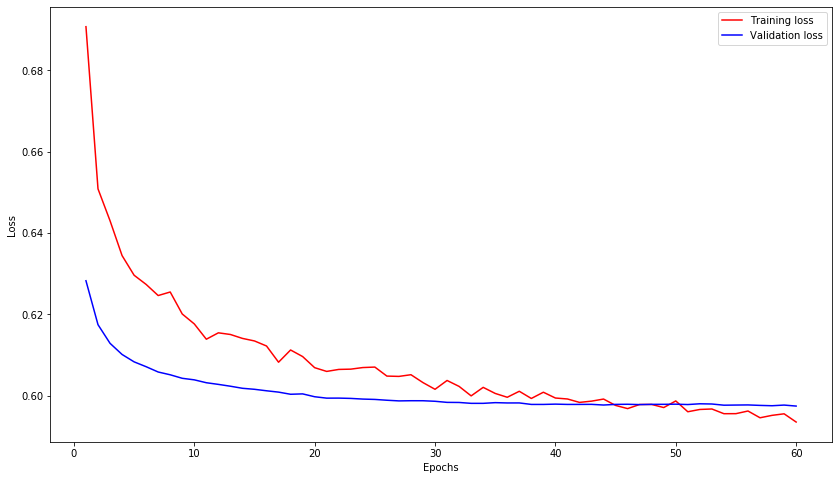

In [27]:
average_val_loss = [np.mean([x[i] for x in all_val_loss]) for i in range(num_epochs)]
average_train_loss = [np.mean([x[i] for x in all_train_loss]) for i in range(num_epochs)]

average_val_acc = [np.mean([x[i] for x in all_val_acc]) for i in range(num_epochs)]
average_train_acc = [np.mean([x[i] for x in all_train_acc]) for i in range(num_epochs)]

print("Train loss: {}, train acc: {}".format(average_train_loss[-1], average_train_acc[-1]))
print("Val loss: {}, val acc: {}".format(average_val_loss[-1], average_val_acc[-1]))

plt.figure(figsize=(14,8))
plt.plot(range(1, len(average_train_loss) + 1), average_train_loss, color="r", label="Training loss")
plt.plot(range(1, len(average_val_loss) + 1), average_val_loss, color="b", label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Performing predictions after getting a satisfactory model

In [41]:
# model = build_model(num_layers=2, num_nodes=128, lr=0.0001, opt="Adam", dropout=True, input_shape=((22,)))
# history = model.fit(X_train_scaled, y_train, epochs=45, batch_size=batch_size, verbose=0)

res = model.predict(X_test_scaled)
res2 = [round(num[0]) for num in res]

print("Rounded test ROC score : {}".format(roc_auc_score(y_test, res2)))
print("Un-rounded test ROC score : {}".format(roc_auc_score(y_test, res)))

Rounded test ROC score : 0.6853582554517134
Un-rounded test ROC score : 0.7499837353487842


In [29]:
model.save_weights('models/ann_weights.h5')

with open('models/ann_architecture.json', 'w') as f:
    f.write(model.to_json())

In [30]:
# Horizontal = y_pred
# Vertical = y_true

confusion_matrix(y_test, res)

array([[1758, 1131],
       [ 229,  734]])